In [92]:
from pathlib import Path
import numpy as np
import pandas as pd
from Classes.Func.KitTools import SaveGen
from Classes.Func.CalculatePart import PerfomAssess
from Classes.ORM.expr import PatientInfo, LabExtube, LabWean
from Classes.ORM.cate import ExtubePSV, ExtubeSumP12, WeanPSV, WeanSumP12

In [93]:
mode_ = 'Extube_SumP12_Nad_xgboost'  # run nad mode then
data_p = r'C:\Main\Data\_\Result\Form\20220515_18_Extube_SumP12_Nad'

mode_info = {
    'Extube': {
        'Lab': LabExtube,
        'PSV': ExtubePSV,
        'SumP12': ExtubeSumP12
    },
    'Wean': {
        'Lab': LabWean,
        'PSV': WeanPSV,
        'SumP12': WeanSumP12
    }
}

In [119]:
def DataLoader(load_path: str):
    p_i_l = []
    m_i_l = mode_.split('_')

    for path in Path(load_path).iterdir():
        if not path.is_file():
            pass
        else:
            p_r = pd.read_csv(path, index_col='method')
            p_info = path.name.split('_')
            p_r_ave = p_r.loc['ave'].to_dict()
            p_r_mp_si = p_r.loc['si', 'mp_jm_t']
            p_r_vt_si = p_r.loc['si', 'v_t']
            p_i_d = {'pid': p_info[0], 'end': int(p_info[1]), 'rid': p_info[2]}
            p_i_d.update(p_r_ave)
            p_i_d['si_mp_jm_t'] = p_r_mp_si
            p_i_d['si_vt'] = p_r_vt_si
            p_i_l.append(p_i_d)

    df_basic = pd.DataFrame(p_i_l)

    src_0, src_1 = PatientInfo, mode_info[m_i_l[0]]['Lab']
    join_info = {'dest': src_0, 'on': src_0.pid == src_1.pid, 'attr': 'pinfo'}
    col_que = [src_1, src_0.age, src_0.sex, src_0.bmi]
    col_order = [src_1.pid]
    cond = src_1.pid.in_(df_basic.pid.to_list())
    que_l = src_1.select(*col_que).join(**join_info).where(cond).order_by(
        *col_order)

    df_que = pd.DataFrame(list(que_l.dicts()))
    df_que = df_que.drop('pid', axis=1)

    df_total = pd.concat([df_basic, df_que], axis=1)
    df_total = df_total.drop(['pid', 'rid'], axis=1)

    # drop featutre nan > 40%
    # df_total = DropByThreshold(df_total, 0.4, 1)
    # drop data nan > 80%
    # df_total = DropByThreshold(df_total, 0.8, 0)

    df_0 = df_total[df_total.end == 0]
    df_1 = df_total[df_total.end == 1]

    return df_0, df_1, df_total

def DropByThreshold(df: pd.DataFrame, per: float, ax_st: int):
    ax_set = int(not ax_st)
    threshold = df.shape[ax_set] * per
    len_raw = df.shape[ax_st]
    df = df.dropna(axis=ax_st, thresh=threshold)
    len_new = df.shape[ax_st]
    print('Drop col/row: {0}'.format(len_raw - len_new))
    return df

In [120]:
_,_, df = DataLoader(data_p)

In [121]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
def SingleLogReg(df, col_l):
    X = df.loc[:, df.columns != col_l]
    y = df.loc[:, df.columns == col_l].values.ravel()
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=0)
    model = LogisticRegression(C=1, max_iter=2000,class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [122]:
dl = []
for col in df.columns[1:]:
    dict_ = {}
    dict_['method'] = col
    df_tmp = df[['end', col]]
    df_tmp = df_tmp.dropna()
    perform = PerfomAssess(df_tmp['end'], df_tmp[col])
    p, rs_pos, rs_neg = perform.PAssess()
    auc, _, _ = perform.AucAssess()
    neg_n = len(df_tmp[df_tmp.end == 0])
    pos_n = len(df_tmp[df_tmp.end == 1])
    dict_['P'] = p
    dict_['AUC'] = auc
    dict_['LogReg'] = SingleLogReg(df_tmp, 'end')
    dict_['succ_rs'] = rs_neg
    dict_['succ_len'] = neg_n
    dict_['fail_rs'] = rs_pos
    dict_['fail_len'] = pos_n
    dl.append(dict_)
df_assess = pd.DataFrame(dl)

c:\Main\Soft\Conda\envs\DF_process\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Main\Soft\Conda\envs\DF_process\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Main\Soft\Conda\envs\DF_process\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Main\Soft\Conda\envs\DF_process\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Main\Soft\Conda\envs\DF_process\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest onl

In [123]:
pd.DataFrame.to_csv(df_assess, 'assess.csv', index=False)

In [124]:
df_p = df_assess.sort_values('P')
df_p = df_p.reset_index(drop=True)
df_p = df_p[0:28]

In [125]:
df_auc = df_p.sort_values('LogReg', ascending=False)
df_auc = df_auc.reset_index(drop=True)

In [126]:
df_auc['LogReg-'] = np.abs(df_auc.LogReg - 0.5)
df_auc = df_auc.sort_values('LogReg-', ascending=False)
df_auc = df_auc.reset_index(drop=True)

In [127]:
df_auc = df_auc[df_auc.method != 'sofa']
df_select = df_auc[(df_auc.P < 0.5) & (df_auc['LogReg-'] > 0.03)][0:12]
df_select = df_select.reset_index(drop=True)
df_select

,method,P,AUC,LogReg,succ_rs,succ_len,fail_rs,fail_len,LogReg-
0,npco2,0.3333,0.553,0.675000,"40.0 (36.15, 43.618)",200,"40.875 (39.502, 43.025)",32,0.175000
1,b_hr,0.0018,0.314,0.665789,"82.75 (76.482, 91.405)",194,"75.61 (71.95, 82.005)",27,0.165789
2,bmi,0.3113,0.578,0.600000,"22.893 (19.531, 25.352)",141,"23.512 (22.055, 25.172)",16,0.100000
3,b_sbp,0.3031,0.561,0.400000,"120.95 (110.58, 135.35)",193,"127.35 (114.85, 136.43)",27,0.100000
4,mp_jm_d,0.2244,0.574,0.593182,3.775 +- 1.957,204,4.218 +- 1.852,32,0.093182
5,rr,0.2393,0.565,0.406818,"20.655 (17.048, 24.31)",204,"22.61 (18.038, 25.022)",32,0.093182
6,si_vt,0.0191,0.635,0.585606,49.644 +- 0.585,204,49.882 +- 0.493,32,0.085606
7,mp_jl_d,0.3915,0.547,0.567424,"0.48 (0.42, 0.532)",204,"0.49 (0.455, 0.54)",32,0.067424
8,rhs,0.2653,0.561,0.566667,"0.6 (0.0, 1.25)",200,"0.835 (0.255, 1.362)",32,0.066667
9,wbg,0.3499,0.448,0.433333,"8.575 (7.238, 10.508)",200,"8.1 (7.248, 9.26)",32,0.066667


In [131]:
df_ = df[['end','si_mp_jm_t', 'si_vt'] + df_select['method'].tolist()]
print(len(df_[df_.end==0]),'|',len(df_[df_.end==1]))
df_.head(20)

204 | 32


,end,si_mp_jm_t,si_vt,npco2,b_hr,bmi,b_sbp,mp_jm_d,rr,si_vt,mp_jl_d,rhs,wbg,mp_jm_t,cr
0,0,50.91,49.27,44.05,77.33,26.122449,107.58,2.84,12.72,49.27,0.43,0.00,15.90,6.18,63.0
1,1,50.34,49.56,32.50,68.70,24.654832,98.75,3.16,20.57,49.56,0.38,-0.38,10.18,7.37,56.0
2,0,50.34,49.75,41.00,71.42,16.563007,108.42,3.66,24.43,49.75,0.37,-0.50,15.70,7.35,NaN
3,0,-56.89,49.49,35.87,79.00,20.545694,97.60,1.84,26.77,49.49,0.16,0.00,10.53,5.36,NaN
4,0,49.91,49.10,34.30,85.32,25.711662,125.45,4.40,25.36,49.10,0.49,3.00,7.25,8.34,NaN
5,0,49.35,49.08,54.50,99.93,25.711662,104.29,4.59,33.42,49.08,0.50,0.00,8.60,9.96,NaN
6,0,50.60,50.26,40.50,121.45,NaN,95.75,5.34,13.56,50.26,0.75,1.20,7.90,8.94,NaN
7,0,47.53,48.69,37.67,73.64,23.437500,121.82,5.74,25.12,48.69,0.54,1.13,9.63,8.90,NaN
8,0,49.72,49.21,44.50,75.69,NaN,140.87,4.70,19.78,49.21,0.48,0.00,7.80,9.66,NaN
9,0,50.33,50.94,31.33,103.80,22.229062,126.90,2.40,16.94,50.94,0.35,0.47,6.63,7.40,NaN


<AxesSubplot:ylabel='Count'>

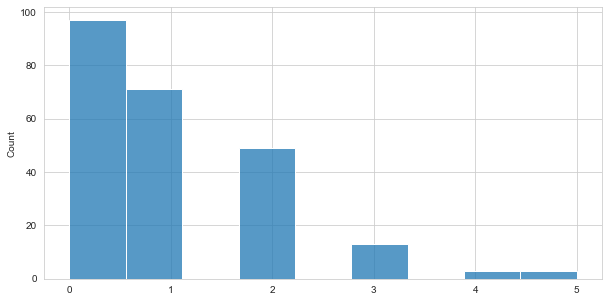

In [132]:
miss_val = df_.isnull().sum(axis=1)
import seaborn as sns
from matplotlib import pyplot as plt
fig_dim = (10, 5)
plt.subplots(figsize=fig_dim)
sns.set_style('whitegrid')
sns.histplot(miss_val)


In [133]:
thresh_st = 2 / (df_.shape[1] -1)
df_ = df_[df_.isnull().sum(axis=1) <= 2]
print(len(df_[df_.end==0]),'|',len(df_[df_.end==1]))

190 | 27


In [134]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from Classes.MLD.processfunc import PreProcess

imp = KNNImputer(missing_values=np.nan, weights='uniform')
df_imp = imp.fit_transform(df_.values.tolist())
for i in range(df_.shape[0]):
    df_.loc[df_.index[i]] = df_imp[i]

In [135]:
pd.DataFrame.to_csv(df_, 'basedata.csv', index=False)